선택된 이미지: /home/byounggun/ultralytics/traffic_train/wide/images/t1_157.jpg
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


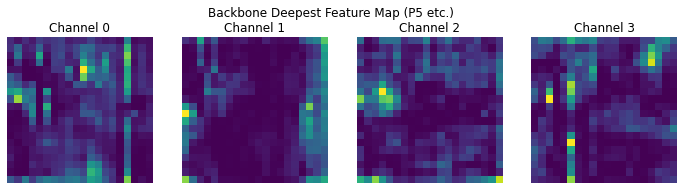

In [11]:
import os
import random
import torch
import matplotlib.pyplot as plt

# 이미지 폴더 경로
image_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"

# 폴더 내 jpg/png 이미지 리스트업
img_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
assert len(img_files) > 0, "폴더에 이미지가 없습니다."

# 랜덤 이미지 선택
image_path = os.path.join(image_dir, random.choice(img_files))
print(f"선택된 이미지: {image_path}")

# 이미지 로드 및 전처리 함수 (예시, 실제 함수와 맞게 수정)
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, img_size=640):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = load_and_preprocess_image(image_path, img_size=640).to(device)

# YOLOv8 백본 모델 (SiameseYOLOv8s) 불러오기
from yolov8_siamese import SiameseYOLOv8s
model = SiameseYOLOv8s(yolo_weights_path='yolov8s.pt').to(device)
model.eval()

# Backbone feature 추출
with torch.no_grad():
    features = model.extract_backbone_features(img_tensor)
    feat = features[-1]  # (1, C, H, W)
    feat = feat.squeeze(0).cpu()  # (C, H, W)

# Feature map 시각화 (앞의 4개 채널만 예시로 출력)
num_channels = min(4, feat.shape[0])
plt.figure(figsize=(12, 3))
for i in range(num_channels):
    plt.subplot(1, num_channels, i+1)
    plt.imshow(feat[i], cmap='viridis')
    plt.title(f"Channel {i}")
    plt.axis('off')
plt.suptitle("Backbone Deepest Feature Map (P5 etc.)")
plt.show()

선택된 파일: t2_266.jpg
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


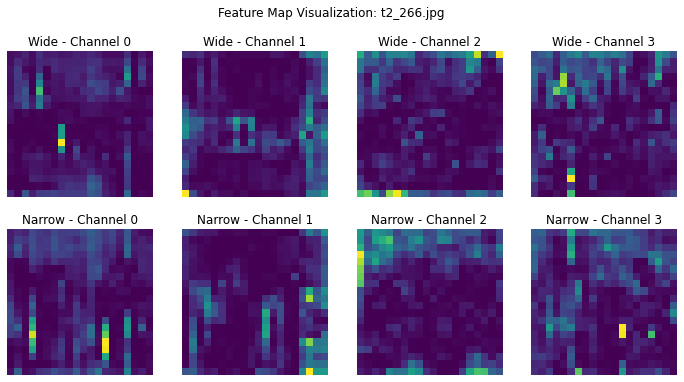

In [15]:
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 이미지 폴더 경로
wide_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"
narrow_dir = "/home/byounggun/ultralytics/traffic_train/narrow/images"

# 두 폴더에 모두 존재하는 파일명 리스트업
wide_files = set([f for f in os.listdir(wide_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
narrow_files = set([f for f in os.listdir(narrow_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
common_files = list(wide_files & narrow_files)
assert len(common_files) > 0, "두 폴더에 공통된 이미지 파일이 없습니다."

# 랜덤 선택
filename = random.choice(common_files)
wide_path = os.path.join(wide_dir, filename)
narrow_path = os.path.join(narrow_dir, filename)
print(f"선택된 파일: {filename}")

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path, img_size=640):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_wide = load_and_preprocess_image(wide_path, img_size=640).to(device)
img_narrow = load_and_preprocess_image(narrow_path, img_size=640).to(device)

# YOLOv8 백본 모델 (SiameseYOLOv8s) 불러오기
from yolov8_siamese import SiameseYOLOv8s
model = SiameseYOLOv8s(yolo_weights_path='yolov8s.pt').to(device)
model.eval()

# Backbone feature 추출
with torch.no_grad():
    feat_wide = model.extract_backbone_features(img_wide)[-1].squeeze(0).cpu()    # (C, H, W)
    feat_narrow = model.extract_backbone_features(img_narrow)[-1].squeeze(0).cpu()# (C, H, W)

# Feature map 시각화 (앞의 4개 채널만 예시)
num_channels = min(4, feat_wide.shape[0], feat_narrow.shape[0])
plt.figure(figsize=(12, 6))
for i in range(num_channels):
    plt.subplot(2, num_channels, i+1)
    plt.imshow(feat_wide[i], cmap='viridis')
    plt.title(f"Wide - Channel {i}")
    plt.axis('off')
    plt.subplot(2, num_channels, num_channels+i+1)
    plt.imshow(feat_narrow[i], cmap='viridis')
    plt.title(f"Narrow - Channel {i}")
    plt.axis('off')
plt.suptitle(f"Feature Map Visualization: {filename}")
plt.show()

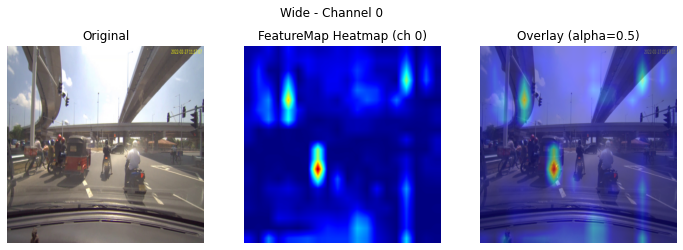

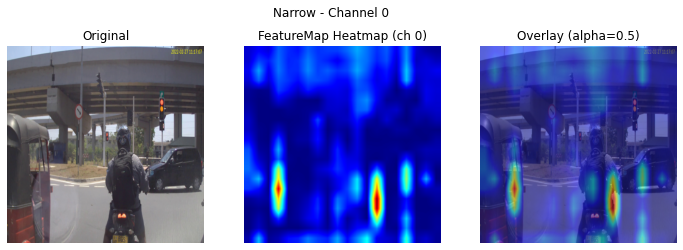

In [17]:
import cv2

def show_feature_overlay(orig_img_path, feature_map, channel=0, alpha=0.5, img_size=640, title=""):
    """
    원본 이미지와 feature map(특정 채널)을 heatmap으로 겹쳐 시각화
    """
    # 원본 이미지 로드 및 리사이즈
    orig = Image.open(orig_img_path).convert("RGB").resize((img_size, img_size))
    orig_np = np.array(orig)

    # feature map (C, H, W) 중 원하는 채널 선택
    fmap = feature_map[channel]
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)  # 0~1 정규화
    # fmap = (fmap * 255).astype(np.uint8)
    fmap = (fmap * 255).cpu().numpy().astype(np.uint8)
    fmap = cv2.resize(fmap, (img_size, img_size))
    heatmap = cv2.applyColorMap(fmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # overlay
    overlay = (alpha * heatmap + (1 - alpha) * orig_np).astype(np.uint8)

    # 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_np)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"FeatureMap Heatmap (ch {channel})")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay (alpha={alpha})")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 예시: wide와 narrow 각각 0번 채널 활성화 overlay
show_feature_overlay(wide_path, feat_wide, channel=0, alpha=0.5, img_size=640, title="Wide - Channel 0")
show_feature_overlay(narrow_path, feat_narrow, channel=0, alpha=0.5, img_size=640, title="Narrow - Channel 0")

선택된 파일: t2_205.jpg


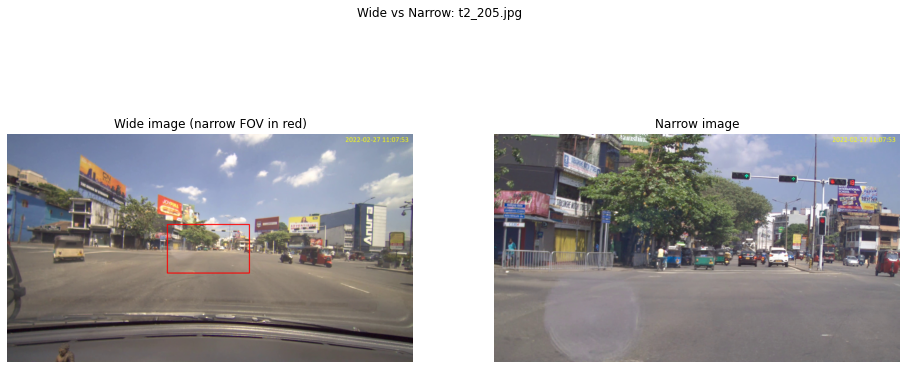

In [70]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# 경로 설정
wide_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"
narrow_dir = "/home/byounggun/ultralytics/traffic_train/narrow/images"
img_w, img_h = 1920, 1080

# wide/narrow에서 공통 파일명 찾기
wide_files = set([f for f in os.listdir(wide_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
narrow_files = set([f for f in os.listdir(narrow_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
common_files = list(wide_files & narrow_files)
assert len(common_files) > 0, "두 폴더에 공통된 이미지 파일이 없습니다."

# 랜덤 선택
filename = random.choice(common_files)
wide_img_path = os.path.join(wide_dir, filename)
narrow_img_path = os.path.join(narrow_dir, filename)
print(f"선택된 파일: {filename}")

# wide 카메라 파라미터
wide_K = np.array([
    [559.258761, 0, 928.108242],
    [0, 565.348774, 518.787048],
    [0, 0, 1]
])
wide_P = np.array([
    [535.711792, 0, 924.086569, 0],
    [0, 558.997375, 510.222325, 0],
    [0, 0, 1, 0]
])

# narrow 카메라 파라미터
narrow_K = np.array([
    [2651.127798, 0, 819.397071],
    [0, 2635.360938, 896.163803],
    [0, 0, 1]
])
narrow_P = np.array([
    [2407.709780, 0, 801.603047, 0],
    [0, 2544.697607, 897.250521, 0],
    [0, 0, 1, 0]
])

# narrow 이미지의 4개 코너 픽셀을 3D로 투영
narrow_corners = np.array([
    [0, 0],
    [img_w-1, 0],
    [img_w-1, img_h-1],
    [0, img_h-1]
], dtype=np.float32)

narrow_K_inv = np.linalg.inv(narrow_K)
rays = []
for u, v in narrow_corners:
    pixel = np.array([u, v, 1.0])
    ray = narrow_K_inv @ pixel
    ray = ray / ray[2]
    rays.append(ray)
rays = np.stack(rays, axis=0)  # (4, 3)

# wide 카메라로 투영
wide_corners = []
for ray in rays:
    X, Y, Z = ray[0], ray[1], 1.0
    pt3d = np.array([X, Y+0.2, Z, 1.0])
    proj = wide_P @ pt3d
    proj = proj / proj[2]
    wide_corners.append([proj[0], proj[1]])
wide_corners = np.array(wide_corners, dtype=np.int32)

# 이미지 불러오기
wide_img = np.array(Image.open(wide_img_path).convert("RGB"))
narrow_img = np.array(Image.open(narrow_img_path).convert("RGB"))

# wide 이미지에 네모 그리기
img_draw = wide_img.copy()
cv2.polylines(img_draw, [wide_corners.reshape(-1, 1, 2)], isClosed=True, color=(255,0,0), thickness=3)

# 시각화
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(img_draw)
plt.title("Wide image (narrow FOV in red)")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(narrow_img)
plt.title("Narrow image")
plt.axis('off')
plt.suptitle(f"Wide vs Narrow: {filename}")
plt.show()

선택된 파일: t1_025.jpg
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


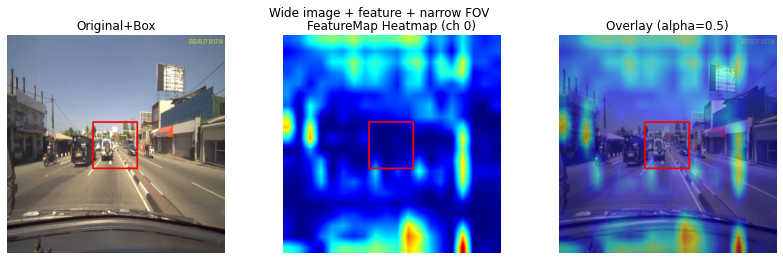

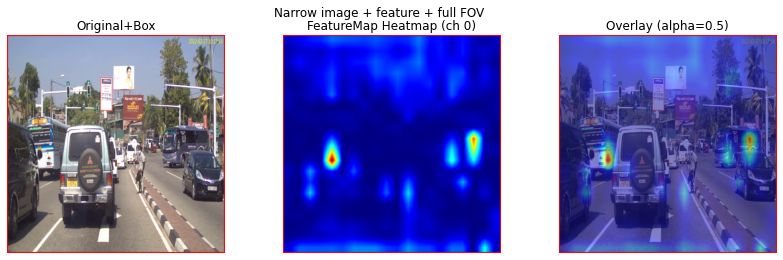

In [86]:
import os
import random
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from yolov8_siamese import SiameseYOLOv8s

# === 1. 경로 및 파일 선택 ===
wide_dir = "/home/byounggun/ultralytics/traffic_train/wide/images"
narrow_dir = "/home/byounggun/ultralytics/traffic_train/narrow/images"
img_w, img_h = 1920, 1080

wide_files = set([f for f in os.listdir(wide_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
narrow_files = set([f for f in os.listdir(narrow_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
common_files = list(wide_files & narrow_files)
assert len(common_files) > 0, "두 폴더에 공통된 이미지 파일이 없습니다."

filename = random.choice(common_files)
wide_path = os.path.join(wide_dir, filename)
narrow_path = os.path.join(narrow_dir, filename)
print(f"선택된 파일: {filename}")

# === 2. 카메라 파라미터 ===
wide_K = np.array([[559.258761, 0, 928.108242],
                   [0, 565.348774, 518.787048],
                   [0, 0, 1]])
wide_P = np.array([[535.711792, 0, 924.086569, 0],
                   [0, 558.997375, 510.222325, 0],
                   [0, 0, 1, 0]])
narrow_K = np.array([[2651.127798, 0, 819.397071],
                     [0, 2635.360938, 896.163803],
                     [0, 0, 1]])
narrow_P = np.array([[2407.709780, 0, 801.603047, 0],
                     [0, 2544.697607, 897.250521, 0],
                     [0, 0, 1, 0]])

# === 3. narrow 이미지의 4개 코너 픽셀을 wide로 투영 (y축 42mm 차이 반영) ===
narrow_corners = np.array([
    [0, 0],
    [img_w-1, 0],
    [img_w-1, img_h-1],
    [0, img_h-1]
], dtype=np.float32)

narrow_K_inv = np.linalg.inv(narrow_K)
rays = []
for u, v in narrow_corners:
    pixel = np.array([u, v, 1.0])
    ray = narrow_K_inv @ pixel
    ray = ray / ray[2]
    rays.append(ray)
rays = np.stack(rays, axis=0)  # (4, 3)

# y축 42mm 차이 반영
wide_corners = []
for ray in rays:
    X, Y, Z = ray[0], ray[1], 1.0
    pt3d_wide = np.array([X, Y + 0.2, Z, 1.0])  # y축 +42mm 이동
    proj = wide_P @ pt3d_wide
    proj = proj / proj[2]
    wide_corners.append([proj[0], proj[1]])
wide_corners = np.array(wide_corners, dtype=np.int32)

# narrow 이미지 네모 (전체)
narrow_box = np.array([
    [0, 0],
    [img_w-1, 0],
    [img_w-1, img_h-1],
    [0, img_h-1]
], dtype=np.int32)

# === 4. 모델 및 전처리 ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseYOLOv8s(yolo_weights_path='yolov8s.pt').to(device)
model.eval()

def load_and_preprocess_image(image_path, img_size=640, device='cpu'):
    img = Image.open(image_path).convert("RGB").resize((img_size, img_size))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img.to(device)

# === 5. feature map 시각화 함수 (박스 추가) ===
def show_feature_overlay_with_box(image_path, model, box, channel=0, alpha=0.5, img_size=640, title=""):
    device = next(model.parameters()).device
    img_tensor = load_and_preprocess_image(image_path, img_size=img_size, device=device)
    with torch.no_grad():
        features = model.extract_backbone_features(img_tensor)
        feat = features[-1].squeeze(0).cpu()  # (C, H, W)
    # 원본 이미지 (시각화용)
    orig = Image.open(image_path).convert("RGB").resize((img_size, img_size))
    orig_np = np.array(orig)
    # feature map (C, H, W) 중 원하는 채널 선택
    fmap = feat[channel]
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
    fmap = (fmap * 255).numpy().astype(np.uint8)
    fmap = cv2.resize(fmap, (img_size, img_size))
    heatmap = cv2.applyColorMap(fmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (alpha * heatmap + (1 - alpha) * orig_np).astype(np.uint8)
    # 박스 좌표도 img_size에 맞게 스케일링
    h0, w0 = orig_np.shape[:2]
    if box.max() > img_size:  # 원본 크기라면 img_size로 맞춤
        scale_x = img_size / img_w
        scale_y = img_size / img_h
        box_scaled = np.stack([[int(x*scale_x), int(y*scale_y)] for x, y in box], axis=0)
    else:
        box_scaled = box
    # 네모 그리기
    img_box = orig_np.copy()
    cv2.polylines(img_box, [box_scaled.reshape(-1, 1, 2)], isClosed=True, color=(255,0,0), thickness=3)
    overlay_box = overlay.copy()
    cv2.polylines(overlay_box, [box_scaled.reshape(-1, 1, 2)], isClosed=True, color=(255,0,0), thickness=3)
    heatmap_box = heatmap.copy()
    cv2.polylines(heatmap_box, [box_scaled.reshape(-1, 1, 2)], isClosed=True, color=(255,0,0), thickness=3)
    # 시각화
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_box)
    plt.title("Original+Box")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_box)
    plt.title(f"FeatureMap Heatmap (ch {channel})")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlay_box)
    plt.title(f"Overlay (alpha={alpha})")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# === 6. wide/narrow 모두 feature+박스 시각화 ===
show_feature_overlay_with_box(wide_path, model, wide_corners, channel=0, alpha=0.5, img_size=640, title="Wide image + feature + narrow FOV")
show_feature_overlay_with_box(narrow_path, model, narrow_box, channel=0, alpha=0.5, img_size=640, title="Narrow image + feature + full FOV")

WARNING ⚠️ no model scale passed. Assuming scale='n'.
모델 예측 결과 (label style):


,class,conf,x1,y1,x2,y2
0,Green-left,0.500003,0,0,1,1
1,Green,0.500002,0,0,1,1
2,Yellow,0.500001,0,0,1,1
3,Count-down,0.500000,0,0,1,1
4,Green-right,0.500000,0,0,1,1
5,Green-up,0.500000,0,0,1,1
6,Red-yellow,0.500000,0,0,1,1


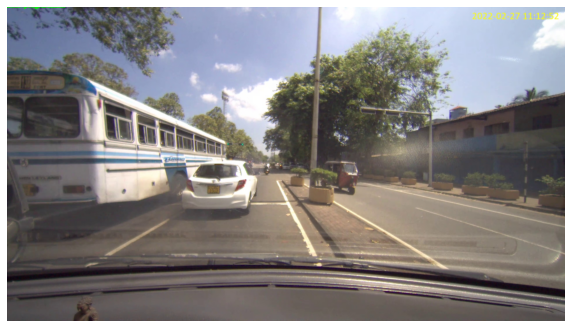

In [110]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from yolov8_dual import DualYOLOv8
# from ultralytics.utils.torch_utils import non_max_suppression
import sys
sys.path.append('/home/byounggun/ultralytics')  # ultralytics가 있는 상위 폴더

from ultralytics.utils.ops import non_max_suppression


# 클래스 이름 로드 (10개만)
with open('/home/byounggun/ultralytics/ultralytics/cfg/datasets/traffic.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)
if isinstance(data_yaml['names'], dict):
    class_names = [data_yaml['names'][i] for i in range(data_yaml['nc'])]
else:
    class_names = data_yaml['names']

def get_image_pairs(wide_img_dir, narrow_img_dir):
    possible_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
    pairs = []
    for f_name_ext in os.listdir(wide_img_dir):
        f_name, f_ext = os.path.splitext(f_name_ext)
        if f_ext.lower() not in possible_extensions:
            continue
        wide_path = os.path.join(wide_img_dir, f_name_ext)
        narrow_path_found = None
        for ext_option in possible_extensions:
            potential_narrow_path = os.path.join(narrow_img_dir, f_name + ext_option)
            if os.path.exists(potential_narrow_path):
                narrow_path_found = potential_narrow_path
                break
        if narrow_path_found:
            pairs.append((wide_path, narrow_path_found))
    return pairs

def preprocess_image(img_path, img_size=640):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0
    return img, img_tensor.unsqueeze(0)

def yolo_postprocess(pred, conf_thres=0.25, iou_thres=0.45, nc=10, device='cpu'):
    # pred: [batch, anchors, 4+1+nc] (raw output)
    pred = torch.sigmoid(pred)
    pred = pred.unsqueeze(0) if pred.ndim == 2 else pred  # [1, anchors, 4+1+nc]
    results = non_max_suppression(pred, conf_thres=conf_thres, iou_thres=iou_thres, nc=nc)
    return results[0].cpu().numpy() if results[0] is not None else np.zeros((0, 6))

def infer_and_visualize(model, wide_img_path, narrow_img_path, conf_thres=0.25, img_size=640):
    wide_img_raw, wide_tensor = preprocess_image(wide_img_path, img_size)
    narrow_img_raw, narrow_tensor = preprocess_image(narrow_img_path, img_size)
    device = next(model.parameters()).device
    wide_tensor = wide_tensor.to(device)
    narrow_tensor = narrow_tensor.to(device)
    model.eval()
    with torch.no_grad():
        raw_pred = model(wide_tensor, narrow_tensor)
        if isinstance(raw_pred, (list, tuple)):
            raw_pred = raw_pred[0]
        # 후처리 적용!
        boxes = yolo_postprocess(raw_pred, conf_thres=conf_thres, nc=len(class_names), device=device)
    h, w, _ = wide_img_raw.shape
    vis_img = wide_img_raw.copy()
    box_list = []
    for row in boxes:
        x1, y1, x2, y2, conf, cls = row[:6]
        # 좌표는 이미 이미지 크기 기준으로 NMS에서 나옴 (ultralytics NMS 기준)
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_idx = int(cls)
        if 0 <= cls_idx < len(class_names):
            label = f"{class_names[cls_idx]}: {conf:.2f}"
            cls_name = class_names[cls_idx]
        else:
            label = f"unknown({cls_idx}): {conf:.2f}"
            cls_name = f"unknown({cls_idx})"
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(vis_img, label, (x1, max(y1-10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        box_list.append({
            "class": cls_name,
            "conf": float(conf),
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2
        })

    # 모델 출력 결과 표 형태로 프린트
    if len(box_list) > 0:
        df = pd.DataFrame(box_list)
        print("모델 예측 결과 (label style):")
        display(df)
    else:
        print("No boxes detected (conf_thres=%.2f)" % conf_thres)

    # bbox 시각화
    plt.figure(figsize=(10,10))
    plt.imshow(vis_img)
    plt.axis('off')
    plt.show()

# 모델 로드
model = DualYOLOv8()
ckpt = torch.load('runs/dual/exp/dual_yolov8_epoch150.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(ckpt)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# 쌍 리스트 생성 및 시각화 예시
wide_dir = '/home/byounggun/ultralytics/traffic_train/wide/images'
narrow_dir = '/home/byounggun/ultralytics/traffic_train/narrow/images'
pairs = get_image_pairs(wide_dir, narrow_dir)

# 예시: 첫 번째 쌍 시각화 및 출력
ind = 0
wide_img_path, narrow_img_path = pairs[ind]
infer_and_visualize(model, wide_img_path, narrow_img_path)
ind += 1